Analyzing treesequence output from SLiM


In [1]:
import msprime, tskit, pyslim, time 
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
#Getting recombination information from slim simulation

#SLiM uses end positions while msprime uses start positions (msprime list will be n + 1)

Mut_rate = 1.5e-8
Rec_rate = 1e-8
#Amp_rec_rate = ??? SHOULD BE HIGHER

Chr_len = 9999
Sep_len = 2
Amplicon_len = 50
Sex_Chr_len = (Chr_len // 5) - Amplicon_len

Positions = [Chr_len, Chr_len + Sep_len,
		(Chr_len * 2) + Sep_len + 1,
		(Chr_len * 2) + (Sep_len * 2) + 1,
		(Chr_len * 2) + (Sep_len * 2) + 2 + Amplicon_len + (Sex_Chr_len),
		(Chr_len * 2) + (Sep_len * 2) + 3 + (Amplicon_len * 2) + (Sex_Chr_len),
		(Chr_len * 2) + (Sep_len * 2) + 4 + (Amplicon_len * 2) + (Sex_Chr_len * 2),
		(Chr_len * 2) + (Sep_len * 2) + 5 + (Amplicon_len * 3) + (Sex_Chr_len * 2),
		(Chr_len * 2) + (Sep_len * 2) + 6 + (Amplicon_len * 3) + (Sex_Chr_len * 3),
		(Chr_len * 2) + (Sep_len * 2) + 7 + (Amplicon_len * 4) + (Sex_Chr_len * 3),
		(Chr_len * 2) + (Sep_len * 2) + 8 + (Amplicon_len * 4) + (Sex_Chr_len * 4),
		(Chr_len * 2) + (Sep_len * 2) + 9 + (Amplicon_len * 5) + (Sex_Chr_len * 4),
		(Chr_len * 2) + (Sep_len * 2) + 10 + (Amplicon_len * 5) + (Sex_Chr_len * 5)]

#No rec in males outside PAR
Male_Recrates = [Rec_rate, 0.5, Rec_rate, 0.5, 0, 0.5, 0, 0.5, 0, 0.5, 0, 0.5, 0]
Female_recrates = [Rec_rate, 0.5, Rec_rate, 0.5, Rec_rate, 0.5, Rec_rate, 0.5, Rec_rate, 0.5, Rec_rate, 0.5, Rec_rate] 

#Recombination maps in tsv files use cM/Mb as a standard
#Rescaling recombination rates accordingly:
Male_Recrates_scaled = [r / 1e-8 for r in Male_Recrates]
Female_Recrates_scaled = [r / 1e-8 for r in Female_recrates]

Female_Recrates_scaled


[1.0,
 50000000.0,
 1.0,
 50000000.0,
 1.0,
 50000000.0,
 1.0,
 50000000.0,
 1.0,
 50000000.0,
 1.0,
 50000000.0,
 1.0]

In [3]:
def ts_processer(ts_file_path, recapitation=False): ################################# numinds
    orig_ts = tskit.load(ts_file_path)
    if recapitation == False:
        rts = orig_ts
    else: #no recapitation needed right now 
        return "Should write function without recapitation"
    #Simplification: discarding less informing nodes from tree
    rng = np.random.default_rng(seed=3)
    alive_inds = pyslim.individuals_alive_at(rts, 0)
    keep_indivs = rng.choice(alive_inds, 100, replace=False) #################################
    keep_nodes = []
    for i in keep_indivs:
        keep_nodes.extend(rts.individual(i).nodes)

    sts = rts.simplify(keep_nodes, keep_input_roots=True) 

    print(f"SIMPLIFICATION:\nBefore, there were {rts.num_samples} sample nodes (and {rts.num_individuals} individuals)\n"
        f"in the tree sequence, and now there are {sts.num_samples} sample nodes\n"
        f"(and {sts.num_individuals} individuals).\n--------------------------\n")
    
    #Adding neutral mutation types after the simulation has occured
    #ACTUALLY WE HAVE ONLY NEUTRAL MUTATION TYPES IN OUR SIMULATION <====== DAVIDE
    next_id = pyslim.next_slim_mutation_id(sts)
    ts = msprime.sim_mutations(
            sts,
            rate=Mut_rate,
            model=msprime.SLiMMutationModel(type=0, next_id=next_id), #using mutation type 0 because its not used in SLiM 
            keep=True, #keeps other mut types 
    )

    print(f"ADDING NEUTRAL MUTATIONS:\nThe tree sequence now has {ts.num_mutations} mutations,\n"
        f"and mean pairwise nucleotide diversity is {ts.diversity():0.3e}.\n--------------------------\n")

    return ts

In [37]:
def TajimasD(ts_list, windows_len=1800):   
    if type(ts_list) == tskit.trees.TreeSequence:
        L = int(ts_list.sequence_length)
        windows = np.linspace(0, L, L//windows_len)
        plt.stairs(ts_list.Tajimas_D(windows=windows), windows/1_000, baseline=None)  # Default is mode="site"
        plt.title("Tajima's D")
        plt.xlabel("Genome position (kb)")
        plt.ylabel("D")
        plt.show()
    elif type(ts_list) == list:
        for ts in ts_list:
            L = int(ts.sequence_length)
            windows = np.linspace(0, L, L//windows_len)
            plt.stairs(ts.Tajimas_D(windows=windows), windows/1_000, baseline=None)
        plt.xlabel("Genome position (kb)")
        plt.ylabel("D")
        plt.show()
    return 0 

def Tmrca(ts_list):
    #Plotting TMRCA for given tree sequence 
    if type(ts_list) == tskit.trees.TreeSequence:      
        #filtering trees with more than one branch 
        trees_onebranch = [tree for tree in ts_list.trees() if len(tree.roots) == 1]
        tmrca = np.zeros(len(trees_onebranch)) #initializing lists
        breakpoints = np.zeros(len(trees_onebranch))
        for tree in ts_list.trees():
            if len(tree.roots) == 1:
                tmrca[tree.index] = tree.time(tree.root)
                breakpoints[tree.index] = tree.interval[0]     #t[0] + (t[1] + t[0] / 2)
            plt.plot(breakpoints / 1000, tmrca, "o")
        plt.ylabel("T_mrca (Generations)")
        plt.xlabel("Position (kb)")
        plt.show()
    elif type(ts_list) == list:
        for ts in ts_list:
            trees_onebranch = [tree for tree in ts.trees() if len(tree.roots) == 1]
            tmrca = np.zeros(len(trees_onebranch)) #initializing lists
            breakpoints = np.zeros(len(trees_onebranch))
            for tree in ts.trees():
                if len(tree.roots) == 1:
                    tmrca[tree.index] = tree.time(tree.root)
                    breakpoints[tree.index] = tree.interval[0]
                    #t[0] + (t[1] + t[0] / 2)
            plt.plot(breakpoints / 1000, tmrca, "o")
        plt.ylabel("T_mrca (Generations)")
        plt.xlabel("Position (kb)")
        plt.show()
    return 0

In [4]:
ts2 = ts_processer("../results/out.trees")

SIMPLIFICATION:
Before, there were 214 sample nodes (and 107 individuals)
in the tree sequence, and now there are 200 sample nodes
(and 105 individuals).
--------------------------

ADDING NEUTRAL MUTATIONS:
The tree sequence now has 183 mutations,
and mean pairwise nucleotide diversity is 3.521e-04.
--------------------------



In [5]:
def ts_visualizer(ts_list, startpos, endpos):
    
    Tmrca(ts_list)
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 3))
    for ts in ts_list:
        L = int(ts.sequence_length)
        windows = np.linspace(0, L, num=L//500)
        ax1.stairs(ts.diversity(windows=windows), windows/1_000, baseline=None)  # Default is mode="site"
        ax1.set_title("Site-based calculation")
        #ax1.set_xlim(4e3, 6e3)
        ax1.set_yscale("log")
        #ax1.set_ylim(1e-6, 1e-2)
        ax2.stairs(ts.diversity(windows=windows, mode="branch"), windows/1_000, baseline=None)
        #ax2.set_xlim(4e3, 6e3)
        ax2.set_yscale("log")
        ax1.set_ylabel("Diversity")
        ax1.set_xlabel("Genome position (kb)")
        ax2.set_xlabel("Genome position (kb)")
        ax2.set_title("Branch-length-based calculation")
    plt.show()

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 3))
    for ts in ts_list:
        afs1 = ts.allele_frequency_spectrum(polarised=True, mode="branch")
        ax1.bar(np.arange(ts.num_samples+1), afs1)
        ax1.set_title("Genome-wide branch-length AFS")
        restricted_ts = ts.keep_intervals([[startpos, endpos]])
        afs2 = restricted_ts.allele_frequency_spectrum(polarised=True, mode="branch")
        ax2.bar(np.arange(restricted_ts.num_samples+1), afs2)
        ax2.set_title(f"Branch-length AFS between {startpos} and {endpos}")
    plt.show()

    TajimasD(ts_list)
    '''
        afs = ts.allele_frequency_spectrum()
        plt.bar(np.arange(ts.num_samples + 1), afs)
        plt.title("Unpolarised allele frequency spectrum")
        plt.show()

    '''
    return 0

In [5]:
def plotter(ts, fun):
    for tree in ts:
        pass
    return 0

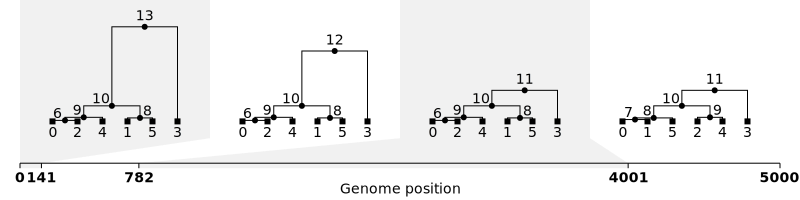

In [9]:
import msprime
from IPython.display import SVG, display

# Simulate an ancestral history for 3 diploid samples under the coalescent
# with recombination on a 5kb region with human-like parameters.
ts1 = msprime.sim_ancestry(
samples=3,
recombination_rate=1e-8,
sequence_length=5_000,
population_size=10_000,
random_seed=123456)
# Visualise the simulated ancestral history.
SVG(ts1.draw_svg())

In [13]:
n_windows = 5
ts2.Tajimas_D(windows=np.linspace(0, ts2.sequence_length, n_windows + 1))
ts = ts2

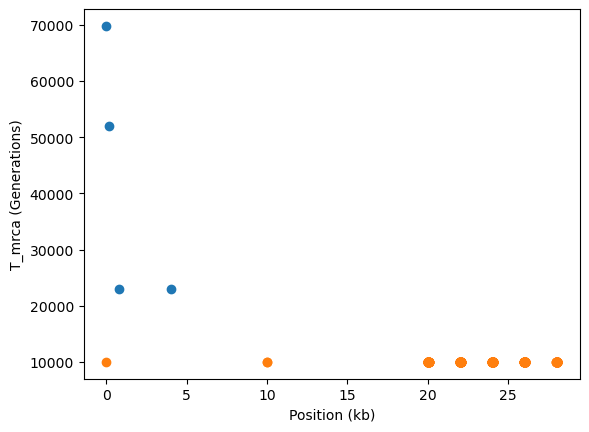

/scratch/usertmp/ipykernel_2415818/2966275299.py:12: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax1.set_yscale("log")


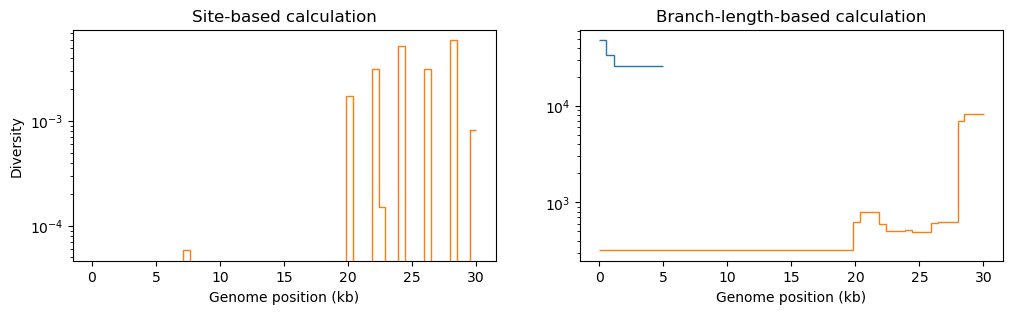

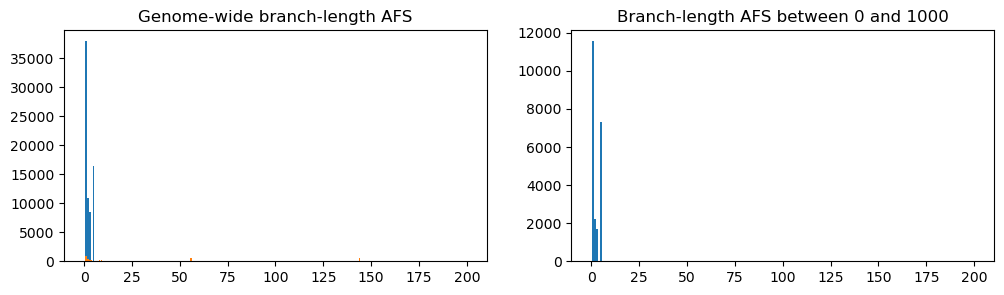

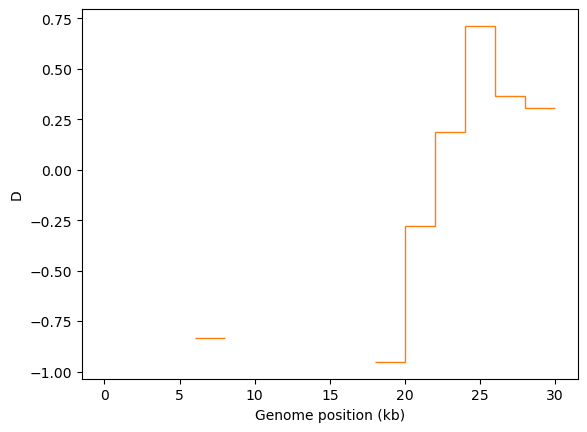

0

In [38]:
ts_visualizer([ts1, ts2], 0, 1000)

In [ ]:
def ts_analyzer(ts_list):
    pass

Tree number 1, which runs from position 10000.0 to 10001.0:


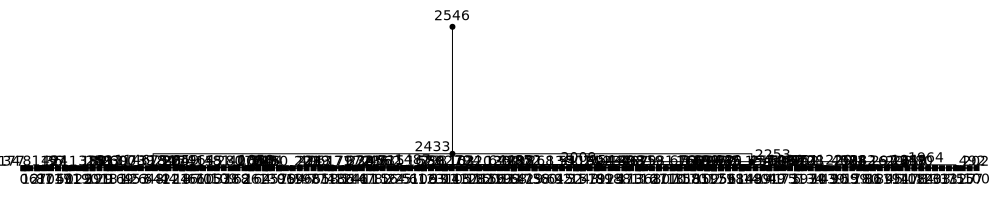

In [23]:
swept_tree = ts.at(10_000)  # or you can get e.g. the nth tree using ts.at_index(n)
intvl = swept_tree.interval
print(f"Tree number {swept_tree.index}, which runs from position {intvl.left} to {intvl.right}:")
# Draw it at a wide size, to make room for all 40 tips
swept_tree.draw_svg(size=(1000, 200))

Genealogy of the first 10 samples for the first 5kb of the genome


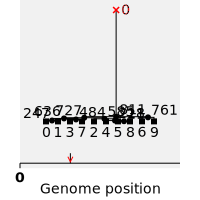

In [24]:
reduced_ts = ts.simplify([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])  # simplify to the first 10 samples
print("Genealogy of the first 10 samples for the first 5kb of the genome")
reduced_ts.draw_svg(x_lim=(0, 5000))

In [28]:
d = ts.diversity()
print(f"Average diversity per unit sequence length = {d:.3G}")

Average diversity per unit sequence length = 0.000345


In [29]:
windows = np.linspace(0, ts.sequence_length, num=5)
d = ts.diversity(windows=windows)
print(windows, d, sep="\n")

[    0.  7502. 15004. 22506. 30008.]
[0.         0.         0.00032951 0.00105048]
